In [1]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.8 MB/s eta 0:00:00


# Importing required libraries

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import unicodedata
from textblob import TextBlob
import plotly.express as px
import contractions
import nltk
from time import time
from nltk.util import ngrams
import regex as re
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import multiprocessing
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Importing the datasets

In [3]:
train = pd.read_csv('../input/poem-classification-nlp/Poem_classification - train_data.csv', encoding = 'UTF-8')
test = pd.read_csv('../input/poem-classification-nlp/Poem_classification - test_data.csv', encoding = 'UTF-8')
train.head()

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [5]:
print(train.shape)
train = train.dropna(inplace = False)
train = train.drop_duplicates()
train = train.reset_index()
print(train.shape)

(841, 2)
(835, 3)


There were a couple of NaN poem values but that's been dealt with.

In [6]:
print(test.shape)
test = test.dropna(inplace = False)
test = test.drop_duplicates()
test = test.reset_index()
print(test.shape)

(150, 2)
(150, 3)


In [7]:
train.Genre.value_counts()

Music          238
Death          229
Environment    227
Affection      141
Name: Genre, dtype: int64

In [8]:
train['Length'] = train['Poem'].apply(len)
test['Length'] = test['Poem'].apply(len)

In [9]:
fig = px.bar(train, x='Length', y='Genre',color = 'Genre')
fig.show()

We observe that **'Affection'** is pretty low compared to the other three genres. However, the other three are pretty similar when frequency's concerned. This can be dealt with by adding synthetic points using **SMOTE** so as to have a balanced dataset in our hands.

# Feature Extraction

In [10]:
def get_avg_word_len(x):
 
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [11]:
def feature_extract(df,d):
    stop = set(stopwords.words('english'))
    df['count'] = df[d].apply(lambda x: len(str(x).split()))
    df['char_count'] = df[d].apply(lambda x: len(x))
    df['nwords'] = df[d].apply(lambda x: len(x.split(' ')))
    #df['avg word_len'] = df[d].apply(lambda x:get_avg_word_len(x))
    df['stop_words_len'] = df[d].apply(lambda x: len([t for t in x.split() if t in stop]))
    df['polarity'] = df[d].map(lambda text: TextBlob(text).sentiment.polarity)

In [12]:
feature_extract(train,'Poem')

In [13]:
train.head()

,index,Genre,Poem,Length,count,char_count,nwords,stop_words_len,polarity
0,1,Music,In the thick brushthey spend the...,205,26,205,50,10,-0.300000
1,2,Music,Storms are generous. ...,191,26,191,50,14,-0.033333
2,3,Music,—After Ana Mendieta Did you carry around the ...,242,42,242,43,12,0.000000
3,4,Music,for Aja Sherrard at 20The portent may itself ...,209,36,209,37,15,-0.291667
4,5,Music,"for Bob Marley, Bavaria, November 1980 Here i...",197,36,197,37,15,0.650000


In [14]:
feature_extract(test,'Poem')

In [15]:
test.head()

,index,Genre,Poem,Length,count,char_count,nwords,stop_words_len,polarity
0,0,Music,A woman walks by the bench I’m sitting onwith ...,203,41,203,41,13,0.300000
1,1,Music,"Because I am a boy, the untouchability of beau...",304,50,304,50,18,-0.041667
2,2,Music,"Because today we did not leave this world,We n...",302,50,302,50,25,0.316667
3,3,Music,"Big Bend has been here, been here. Shouldn’t i...",289,50,289,50,18,0.080000
4,4,Music,"I put shells there, along the lip of the road....",192,24,192,50,6,0.000000


Could think of only these features when extraction's concerned but suggestions to add more are welcome.

# Frequency Distribution of POS Tags based on Genre

In [16]:
def countPosbyGenre(dataframe, pos) : 
    genreDict = {}
    for i in range(len(dataframe)) : 
        if dataframe.Genre.iloc[i] not in genreDict.keys() : 
            genreDict[dataframe.Genre.iloc[i]] = dataframe.Poem.iloc[i]
        else : 
            genreDict[dataframe.Genre.iloc[i]] += dataframe.Poem.iloc[i]
    
    for key in genreDict.keys() : 
        genreDict[key] = nltk.pos_tag(genreDict[key].split()) 
        counter = 0 
        for i in range(len(genreDict[key])) :
            if genreDict[key][i][1] == pos : 
                counter += 1 
        genreDict[key] = counter 

    return genreDict

In [17]:
tags = ['NN','RB','VB','PRP']
for tag in tags:
    print(f'{tag} --> {countPosbyGenre(train, tag)}')

NN --> {'Music': 2362, 'Death': 2274, 'Affection': 1494, 'Environment': 2310}
RB --> {'Music': 385, 'Death': 407, 'Affection': 249, 'Environment': 343}
VB --> {'Music': 429, 'Death': 427, 'Affection': 238, 'Environment': 290}
PRP --> {'Music': 612, 'Death': 556, 'Affection': 343, 'Environment': 391}


In [18]:
for tag in tags:
    print(f'{tag} --> {countPosbyGenre(test, tag)}')

NN --> {'Music': 127, 'Death': 132, 'Affection': 1002, 'Environment': 222}
RB --> {'Music': 19, 'Death': 24, 'Affection': 154, 'Environment': 40}
VB --> {'Music': 24, 'Death': 31, 'Affection': 196, 'Environment': 27}
PRP --> {'Music': 28, 'Death': 38, 'Affection': 260, 'Environment': 42}


Comapring just a couple of tags, we observe that:
* Noun (NN) tag occurs more for the 'Affection' genre in Test set whereas it's the opposite scenario when it comes to Train set (which might affect while model building ig).
* Adverbs (RB) are pretty low in comparison to the other tags which could be kind of expected when it comes to poems.
* Even in Verbs (VB) and Pronouns (PRP) we do have a dissimilarity problem when it comes to comparing the Train and Test sets.

# Text Preprocessing

In [19]:
def clean_it(df):
    lemmatizer = WordNetLemmatizer()
    snow = SnowballStemmer(language='english')
    stop = set(stopwords.words('english'))
    for i in tqdm(range(len(df))):
        df['Poem'][i] = str(df['Poem'][i])
        df['Poem'][i] = re.sub('\n', ' ', df['Poem'][i])
        df['Poem'][i] = re.sub('_','',df['Poem'][i])
        df['Poem'][i] = ' '.join(df['Poem'][i].split())
        df['Poem'][i] = re.sub(r'\d+', '', df['Poem'][i])
        df['Poem'][i] = re.sub("[\(\[].*?[\)\]]", "", df['Poem'][i])
        df['Poem'][i] = re.sub("[()]",'', df['Poem'][i])
        df['Poem'][i] = df['Poem'][i].lower()
        df['Poem'][i] = contractions.fix(df['Poem'][i])
        df['Poem'][i] = re.sub(r'[^\w\s]', '', df['Poem'][i])
        df['Poem'][i] = re.sub(" +", ' ', df['Poem'][i])  
        t = ''
        for word in df['Poem'][i].split(' '):
            if word not in stop and len(word)>2:
                #t += ' ' + snow.stem(word)
                t += ' ' + lemmatizer.lemmatize(word)
        df['Poem'][i] = t.strip()

Preferred lemmatization here instead of stemming as the former considers the context of the word rather than chopping off to just its root form. However, it takes longer time when it comes to lemmatization hence should be looked at when used for larger datasets.
Other than that, fixed contractions and removed the stopwords which would otherwise prove to be a nuisance during the model building stage.

In [20]:
clean_it(train)
clean_it(test)

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
def generate_ngrams(text,ngram):
    stop = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split(' ') if word not in stop)
    words = [word for word in text.split(" ")]  
    temp = zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [22]:
grams = []
for i in range(len(train)):
    grams.extend(generate_ngrams(train['Poem'][i],3))    

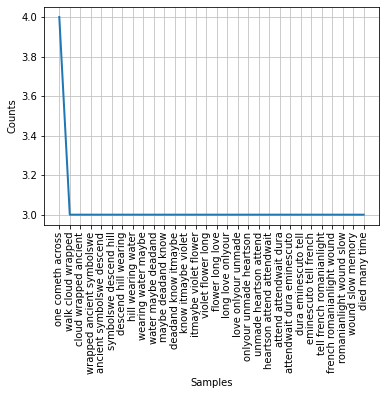

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
fdist = nltk.FreqDist(grams)
fdist.plot(30)

# Word Embeddings

Not much here, really. Just wanted to look a for a paveway towards Information Retreival wherein if some query is provided, the model would provide similar documents as its output. However, my knowledge pertaining to Word2Vec isn't that far fetched hence had to settle with similar words and stuff.

In [24]:
cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count = 20,
                     window = 2,
                     vector_size = 300,
                     sample = 6e-5, 
                     alpha = 0.03, 
                     min_alpha = 0.0007, 
                     negative = 20,
                     workers = cores-1)

Building the vocab

In [25]:
t = time()
w2v_model.build_vocab([g.split() for g in grams] , progress_per = 10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [26]:
len(w2v_model.wv.key_to_index.keys())

476

Parameters of the training:
* total_examples = int - Count of sentences
* epochs = int - Number of iterations over the corpus

In [27]:
t = time()
w2v_model.train(train.Poem, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient

In [28]:
w2v_model.init_sims(replace=True)

In [29]:
# Saving the model
w2v_model.wv.save_word2vec_format('custom_glove_300d.txt')
# Loading it
w2v_model = KeyedVectors.load_word2vec_format('custom_glove_300d.txt')

Most dissimilar terms

In [30]:
w2v_model.most_similar(negative=["blue"])

[('go', 0.17124894261360168),
 ('first', 0.13902850449085236),
 ('quiet', 0.1364378035068512),
 ('toward', 0.13520337641239166),
 ('think', 0.13492384552955627),
 ('part', 0.1275189220905304),
 ('wind', 0.1263001710176468),
 ('white', 0.12049804627895355),
 ('fence', 0.11774977296590805),
 ('throat', 0.11739947646856308)]

Most similar terms

In [31]:
w2v_model.most_similar(positive=["dark"])

[('open', 0.19612173736095428),
 ('looking', 0.1735713928937912),
 ('person', 0.16421818733215332),
 ('walk', 0.15566405653953552),
 ('island', 0.14508208632469177),
 ('girl', 0.13195320963859558),
 ('may', 0.12884578108787537),
 ('come', 0.1280348300933838),
 ('came', 0.11913197487592697),
 ('bring', 0.11674483120441437)]

Most similar to word

In [32]:
w2v_model.similar_by_word('child')

[('mouth', 0.15086530148983002),
 ('tell', 0.14985491335391998),
 ('make', 0.14567898213863373),
 ('bed', 0.14198017120361328),
 ('build', 0.1349385380744934),
 ('men', 0.13320991396903992),
 ('sometimes', 0.1297365427017212),
 ('parking', 0.12646041810512543),
 ('light', 0.12476848065853119),
 ('lake', 0.11796577274799347)]

# Topic Modelling with LDA

The reason behind trying Topic Modelling out was to discover the themes that are inherently hidden by analyzing the words of the original texts.

In [33]:
stop = set(stopwords.words('english'))
vect = TfidfVectorizer(stop_words = stop, max_features = 1000)
vect_text = vect.fit_transform(train['Poem'])

In [34]:
search_params = {'n_components': [0, 2, 4, 8, 12], 'learning_decay': [.5, .7]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vect_text)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7],
                         'n_components': [0, 2, 4, 8, 12]})

In [35]:
model.best_params_

{'learning_decay': 0.5, 'n_components': 2}

In [36]:
n_topics = 4
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit(vect_text)

# Print the top 10 words per topic
n_words = 10
feature_names = vect.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")
    print('\n\n\n')
    
topic_result = model_lda.transform(vect_text)
train['topic']  = topic_result.argmax(axis=1)

Topic 0: wave back come one hand white night love way like




Topic 1: always thing deep mean first dying one dream never get




Topic 2: would like see one say heart let love tree mother




Topic 3: time day long like still red snow child one winter






These are the four different topics that the poems got classified with.

In [37]:
train

,index,Genre,Poem,Length,count,char_count,nwords,stop_words_len,polarity,topic
0,1,Music,thick brushthey spend hottest part day soaking...,205,26,205,50,10,-0.300000,2
1,2,Music,storm generous something easy surrender sittin...,191,26,191,50,14,-0.033333,2
2,3,Music,ana mendieta carry around matin star hold fore...,242,42,242,43,12,0.000000,2
3,4,Music,aja sherrard portent may memory wallace steven...,209,36,209,37,15,-0.291667,1
4,5,Music,bob marley bavaria november brilliant morning ...,197,36,197,37,15,0.650000,1
...,...,...,...,...,...,...,...,...,...,...
830,836,Environment,make much fragmentary blue bird butterfly flow...,306,56,306,56,18,0.057500,2
831,837,Environment,woman wish know name could silence house front...,253,46,253,46,18,-0.166667,2
832,838,Environment,yonder kiosk beside creek paddle swift caque t...,237,41,237,41,16,0.250000,1
833,839,Environment,come fetch work tonight supper table see leave...,291,56,291,50,20,0.170000,2


In [38]:
train[train.topic == 1]['Poem']

3      aja sherrard portent may memory wallace steven...
4      bob marley bavaria november brilliant morning ...
15     lush field shadow static hush radial itch prim...
28     exhibition gravedad los asuntos mexican russia...
30     willie cole artist eye catch breath fire lifti...
                             ...                        
809    today make poet word ownand utter plaintive un...
818    still grows winter fingernail witch femmes gre...
822    young hid porch star throat got little older m...
823    young dwelt valeby misty fen rang night thus m...
832    yonder kiosk beside creek paddle swift caque t...
Name: Poem, Length: 121, dtype: object

In [39]:
train.head()

,index,Genre,Poem,Length,count,char_count,nwords,stop_words_len,polarity,topic
0,1,Music,thick brushthey spend hottest part day soaking...,205,26,205,50,10,-0.300000,2
1,2,Music,storm generous something easy surrender sittin...,191,26,191,50,14,-0.033333,2
2,3,Music,ana mendieta carry around matin star hold fore...,242,42,242,43,12,0.000000,2
3,4,Music,aja sherrard portent may memory wallace steven...,209,36,209,37,15,-0.291667,1
4,5,Music,bob marley bavaria november brilliant morning ...,197,36,197,37,15,0.650000,1


In [40]:
train.Genre.value_counts()

Music          238
Death          229
Environment    227
Affection      141
Name: Genre, dtype: int64

In [41]:
train.topic.value_counts()

2    316
3    255
0    143
1    121
Name: topic, dtype: int64

We notice a similar frequency distribution of Genre and topics.

# Model Building

# 1. **Naive Bayes**

<AxesSubplot:xlabel='Genre', ylabel='count'>

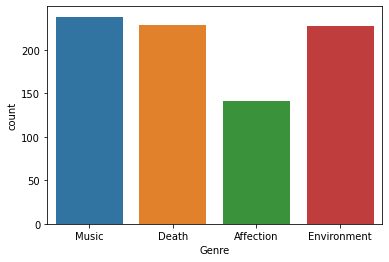

In [42]:
sns.countplot(train['Genre'])

<AxesSubplot:xlabel='Genre', ylabel='count'>

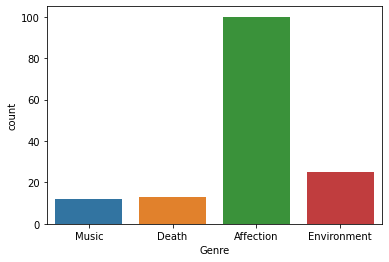

In [43]:
sns.countplot(test['Genre'])

Encoding the **'Genre'** variable.

In [44]:
le = LabelEncoder()
train['Genre'] = le.fit_transform(train['Genre'])
test['Genre'] = le.transform(test['Genre'])

In [45]:
y_train = train.Genre.values
y_test = test.Genre.values
x_train = train.drop('Genre', axis = 1)
x_test = test.drop('Genre', axis = 1)

In [46]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(835, 9) (835,)
(150, 8) (150,)


In [47]:
tfidf_vect = TfidfVectorizer()
x_train_tfidf = tfidf_vect.fit_transform(x_train.Poem)
x_train_tfidf.shape

(835, 8490)

In [48]:
x_test_tfidf = tfidf_vect.transform(x_test.Poem)

Using Multinomial Naive Bayes in this case.

In [49]:
clf = MultinomialNB().fit(x_train_tfidf, train.Genre)
predicted = clf.predict(x_test_tfidf)
np.mean(predicted == y_test)

0.14666666666666667

Time for Gaussian NB.

In [50]:
clf = GaussianNB().fit(x_train_tfidf.toarray(), train.Genre)
predicted = clf.predict(x_test_tfidf.toarray())
print(np.round(np.mean(predicted == y_test),3))

0.153


# 2. **Support Vector Classifier**

In [51]:
clf = SVC().fit(x_train_tfidf.toarray(), train.Genre)
predicted = clf.predict(x_test_tfidf.toarray())
np.mean(predicted == y_test)

0.17333333333333334

# 3. **xG Boost Classifier**

In [52]:
clf = XGBClassifier().fit(x_train_tfidf.toarray(), train.Genre)
predicted = clf.predict(x_test_tfidf.toarray())
np.mean(predicted == y_test)

0.35333333333333333

Out of all the ML models, xG boost fared out with 33 percent accuracy.

# 4. **Using Tensorflow**

In [53]:
data = pd.concat([train,test], axis = 0)
data = data.dropna()

In [54]:
poems = np.array(data['Poem'])
genres = np.array(data['Genre'])

In [55]:
poems.shape, genres.shape

((835,), (835,))

In [56]:
train_poems = poems[:900]
test_poems = poems[900:]
train_genres = genres[:900]
test_genres = genres[900:]

In [57]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_poems)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_poems)
training_padded = pad_sequences(training_sequences, maxlen=200, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(test_poems)
testing_padded = pad_sequences(testing_sequences, maxlen=200, padding='post', truncating='post')

In [58]:
training_padded = np.array(training_padded)
train_genres = np.array(train_genres)
testing_padded = np.array(testing_padded)
test_genres = np.array(test_genres)

In [59]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(10000,16,input_length=200))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dense(25,activation='relu'))
model.add(tf.keras.layers.Dense(4,activation='softmax'))
opt = tf.keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                850       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 104       
Total params: 162,229
Trainable params: 162,229
Non-trainable params: 0
__________________________________________________

2022-10-18 11:52:48.799334: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [60]:
num_epochs = 100
history = model.fit(training_padded, train_genres, epochs=num_epochs, validation_data=(testing_padded, test_genres), verbose=2)

2022-10-18 11:52:49.058041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
27/27 - 1s - loss: 1.3804 - accuracy: 0.2719
Epoch 2/100
27/27 - 0s - loss: 1.3732 - accuracy: 0.2719
Epoch 3/100
27/27 - 0s - loss: 1.3688 - accuracy: 0.2719
Epoch 4/100
27/27 - 0s - loss: 1.3676 - accuracy: 0.2862
Epoch 5/100
27/27 - 0s - loss: 1.3669 - accuracy: 0.2850
Epoch 6/100
27/27 - 0s - loss: 1.3676 - accuracy: 0.2850
Epoch 7/100
27/27 - 0s - loss: 1.3661 - accuracy: 0.2850
Epoch 8/100
27/27 - 0s - loss: 1.3656 - accuracy: 0.2850
Epoch 9/100
27/27 - 0s - loss: 1.3654 - accuracy: 0.2707
Epoch 10/100
27/27 - 0s - loss: 1.3649 - accuracy: 0.2671
Epoch 11/100
27/27 - 0s - loss: 1.3640 - accuracy: 0.2922
Epoch 12/100
27/27 - 0s - loss: 1.3632 - accuracy: 0.3234
Epoch 13/100
27/27 - 0s - loss: 1.3630 - accuracy: 0.2802
Epoch 14/100
27/27 - 0s - loss: 1.3614 - accuracy: 0.3713
Epoch 15/100
27/27 - 0s - loss: 1.3598 - accuracy: 0.4347
Epoch 16/100
27/27 - 0s - loss: 1.3588 - accuracy: 0.3102
Epoch 17/100
27/27 - 0s - loss: 1.3557 - accuracy: 0.3569
Epoch 18/100
27/27 - 0s

This provides the best results with about 88 percent accuracy.

A couple of things, should have gone for SMOTE and Data Augmentation to increase model performance.

Anyways that's it ig. Do let me know how to improve the interpretability when it comes to LDA and any modifications before the model building stage. Other feedbacks are appreciated too. Thanks!